<a href="https://colab.research.google.com/github/stemgene/-Approaches-of-Human-Activity-Recognition-Using-Smartphones/blob/master/Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
import pandas as pd
import numpy as np
import pandas_profiling
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from sklearn.decomposition import PCA
import time
%matplotlib inline

## 2. Data Collection and Preparation

### 2.2 Source of dataset and total number of records, number of variables

In [0]:
df = pd.read_csv('/gdrive/My Drive/UR/DSC483/MiniProject/DataSet_HAR.csv')
print(df.shape)
df.tail()

(10299, 563)


,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,tBodyAcc-max()-Y,tBodyAcc-max()-Z,tBodyAcc-min()-X,tBodyAcc-min()-Y,tBodyAcc-min()-Z,tBodyAcc-sma(),tBodyAcc-energy()-X,tBodyAcc-energy()-Y,tBodyAcc-energy()-Z,tBodyAcc-iqr()-X,tBodyAcc-iqr()-Y,tBodyAcc-iqr()-Z,tBodyAcc-entropy()-X,tBodyAcc-entropy()-Y,tBodyAcc-entropy()-Z,"tBodyAcc-arCoeff()-X,1","tBodyAcc-arCoeff()-X,2","tBodyAcc-arCoeff()-X,3","tBodyAcc-arCoeff()-X,4","tBodyAcc-arCoeff()-Y,1","tBodyAcc-arCoeff()-Y,2","tBodyAcc-arCoeff()-Y,3","tBodyAcc-arCoeff()-Y,4","tBodyAcc-arCoeff()-Z,1","tBodyAcc-arCoeff()-Z,2","tBodyAcc-arCoeff()-Z,3","tBodyAcc-arCoeff()-Z,4","tBodyAcc-correlation()-X,Y","tBodyAcc-correlation()-X,Z","tBodyAcc-correlation()-Y,Z",...,fBodyBodyAccJerkMag-entropy(),fBodyBodyAccJerkMag-maxInds,fBodyBodyAccJerkMag-meanFreq(),fBodyBodyAccJerkMag-skewness(),fBodyBodyAccJerkMag-kurtosis(),fBodyBodyGyroMag-mean(),fBodyBodyGyroMag-std(),fBodyBodyGyroMag-mad(),fBodyBodyGyroMag-max(),fBodyBodyGyroMag-min(),fBodyBodyGyroMag-sma(),fBodyBodyGyroMag-energy(),fBodyBodyGyroMag-iqr(),fBodyBodyGyroMag-entropy(),fBodyBodyGyroMag-maxInds,fBodyBodyGyroMag-meanFreq(),fBodyBodyGyroMag-skewness(),fBodyBodyGyroMag-kurtosis(),fBodyBodyGyroJerkMag-mean(),fBodyBodyGyroJerkMag-std(),fBodyBodyGyroJerkMag-mad(),fBodyBodyGyroJerkMag-max(),fBodyBodyGyroJerkMag-min(),fBodyBodyGyroJerkMag-sma(),fBodyBodyGyroJerkMag-energy(),fBodyBodyGyroJerkMag-iqr(),fBodyBodyGyroJerkMag-entropy(),fBodyBodyGyroJerkMag-maxInds,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
10294,0.310155,-0.053391,-0.099109,-0.287866,-0.140589,-0.215088,-0.356083,-0.148775,-0.232057,0.185361,-0.160309,-0.131106,0.354922,0.188452,0.362922,-0.197803,-0.744913,-0.854291,-0.721311,-0.567761,-0.368876,-0.277531,0.128951,0.250479,0.204483,-0.336571,0.119363,0.114556,0.069925,-0.225459,0.131274,0.013961,0.163305,-0.510918,0.525957,-0.467399,0.117754,-0.258908,-0.310537,-0.022682,...,0.214449,-0.904762,-0.110967,-0.157943,-0.583573,-0.477844,-0.571234,-0.515544,-0.605614,-0.861894,-0.477844,-0.862898,-0.498797,0.491522,-0.897436,0.093839,-0.410787,-0.711904,-0.601424,-0.618829,-0.558146,-0.698564,-0.770173,-0.601424,-0.917701,-0.536164,0.365783,-0.904762,0.074472,-0.376278,-0.750809,-0.337422,0.346295,0.884904,-0.698885,-0.651732,0.274627,0.184784,24,WALKING_UPSTAIRS
10295,0.363385,-0.039214,-0.105915,-0.305388,0.028148,-0.196373,-0.373540,-0.030036,-0.270237,0.185361,-0.035922,-0.131106,0.414650,-0.021580,0.218490,-0.186842,-0.755958,-0.794744,-0.708265,-0.549364,-0.353944,-0.386571,0.311991,0.277052,0.112971,-0.141648,-0.020623,0.124019,0.133963,-0.171622,0.087886,0.070093,0.085764,-0.416882,0.387530,-0.225698,-0.039828,-0.249325,-0.293864,0.031417,...,0.267662,-0.904762,0.125434,-0.223759,-0.689000,-0.491855,-0.556577,-0.525429,-0.664599,-0.682096,-0.491855,-0.861670,-0.639320,0.469640,-1.000000,0.092162,-0.449349,-0.795229,-0.566344,-0.592507,-0.530253,-0.662435,-0.947627,-0.566344,-0.904083,-0.534418,0.402907,-0.904762,0.101859,-0.320418,-0.700274,-0.736701,-0.372889,-0.657421,0.322549,-0.655181,0.273578,0.182412,24,WALKING_UPSTAIRS
10296,0.349966,0.030077,-0.115788,-0.329638,-0.042143,-0.250181,-0.388017,-0.133257,-0.347029,0.007471,-0.035922,-0.172677,0.402517,-0.021580,0.218490,-0.232233,-0.772925,-0.818344,-0.745217,-0.536007,-0.527129,-0.560587,0.342902,0.411568,0.167789,-0.093074,-0.146011,0.400424,-0.123618,-0.117599,0.006040,0.170446,0.047362,-0.204792,0.077011,0.291691,-0.347075,-0.351080,-0.417738,0.118835,...,0.239540,-0.904762,0.111669,0.182278,-0.095859,-0.601283,-0.563327,-0.557262,-0.619462,-0.807723,-0.601283,-0.88842

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10299 entries, 0 to 10298
Columns: 563 entries, tBodyAcc-mean()-X to Activity
dtypes: float64(561), int64(1), object(1)
memory usage: 44.2+ MB


### 2.3 Exploratory Analysis

Check the missing or None value

In [0]:
print("Any missing value in dataset:",df.isnull().values.any())

Any missing value in dataset: False


Check whether the dataset is imbalanced

In [0]:
#Frequency distribution of classes"
df_outcome = pd.crosstab(index=df["Activity"], columns="count") 
df_outcome

col_0,count
Activity,
LAYING,1944
SITTING,1777
STANDING,1906
WALKING,1722
WALKING_DOWNSTAIRS,1406
WALKING_UPSTAIRS,1544


In [0]:
temp = df["Activity"].value_counts()
temp.index.to_list()

['LAYING',
 'STANDING',
 'SITTING',
 'WALKING',
 'WALKING_UPSTAIRS',
 'WALKING_DOWNSTAIRS']

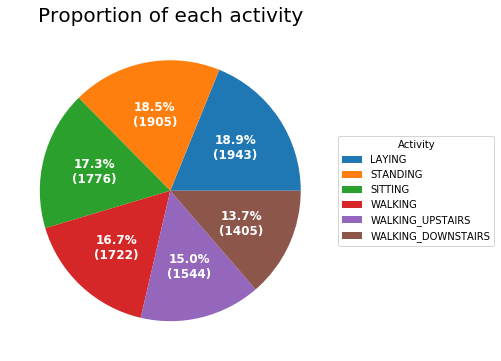

In [0]:
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw=dict(aspect="equal"))
temp = df["Activity"].value_counts()
recipe = temp.index.to_list()

data = temp.to_list()
ingredients = [x.split()[-1] for x in recipe]


def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d})".format(pct, absolute)


wedges, texts, autotexts = ax.pie(data, autopct=lambda pct: func(pct, data),
                                  textprops=dict(color="w"))

ax.legend(wedges, ingredients,
          title="Activity",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.setp(autotexts, size=12, weight="bold")

ax.set_title("Proportion of each activity", fontsize=20)

plt.show()

### 2.3 Data preprocessing

Map the label

In [0]:
labelencoder = LabelEncoder()
df['Label'] = labelencoder.fit_transform(df['Activity'])
df.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,tBodyAcc-max()-Y,tBodyAcc-max()-Z,tBodyAcc-min()-X,tBodyAcc-min()-Y,tBodyAcc-min()-Z,tBodyAcc-sma(),tBodyAcc-energy()-X,tBodyAcc-energy()-Y,tBodyAcc-energy()-Z,tBodyAcc-iqr()-X,tBodyAcc-iqr()-Y,tBodyAcc-iqr()-Z,tBodyAcc-entropy()-X,tBodyAcc-entropy()-Y,tBodyAcc-entropy()-Z,"tBodyAcc-arCoeff()-X,1","tBodyAcc-arCoeff()-X,2","tBodyAcc-arCoeff()-X,3","tBodyAcc-arCoeff()-X,4","tBodyAcc-arCoeff()-Y,1","tBodyAcc-arCoeff()-Y,2","tBodyAcc-arCoeff()-Y,3","tBodyAcc-arCoeff()-Y,4","tBodyAcc-arCoeff()-Z,1","tBodyAcc-arCoeff()-Z,2","tBodyAcc-arCoeff()-Z,3","tBodyAcc-arCoeff()-Z,4","tBodyAcc-correlation()-X,Y","tBodyAcc-correlation()-X,Z","tBodyAcc-correlation()-Y,Z",...,fBodyBodyAccJerkMag-maxInds,fBodyBodyAccJerkMag-meanFreq(),fBodyBodyAccJerkMag-skewness(),fBodyBodyAccJerkMag-kurtosis(),fBodyBodyGyroMag-mean(),fBodyBodyGyroMag-std(),fBodyBodyGyroMag-mad(),fBodyBodyGyroMag-max(),fBodyBodyGyroMag-min(),fBodyBodyGyroMag-sma(),fBodyBodyGyroMag-energy(),fBodyBodyGyroMag-iqr(),fBodyBodyGyroMag-entropy(),fBodyBodyGyroMag-maxInds,fBodyBodyGyroMag-meanFreq(),fBodyBodyGyroMag-skewness(),fBodyBodyGyroMag-kurtosis(),fBodyBodyGyroJerkMag-mean(),fBodyBodyGyroJerkMag-std(),fBodyBodyGyroJerkMag-mad(),fBodyBodyGyroJerkMag-max(),fBodyBodyGyroJerkMag-min(),fBodyBodyGyroJerkMag-sma(),fBodyBodyGyroJerkMag-energy(),fBodyBodyGyroJerkMag-iqr(),fBodyBodyGyroJerkMag-entropy(),fBodyBodyGyroJerkMag-maxInds,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity,Label
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,-0.567378,-0.744413,0.852947,0.685845,0.814263,-0.965523,-0.999945,-0.999863,-0.994612,-0.994231,-0.987614,-0.943220,-0.407747,-0.679338,-0.602122,0.929294,-0.853011,0.359910,-0.058526,0.256892,-0.224848,0.264106,-0.095246,0.278851,-0.465085,0.491936,-0.190884,0.376314,0.435129,0.660790,...,-0.936508,0.346989,-0.516080,-0.802760,-0.980135,-0.961309,-0.973653,-0.952264,-0.989498,-0.980135,-0.999240,-0.992656,-0.701291,-1.000000,-0.128989,0.586156,0.374605,-0.991990,-0.990697,-0.989941,-0.992448,-0.991048,-0.991990,-0.999937,-0.990458,-0.871306,-1.000000,-0.074323,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,1,STANDING,2
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,-0.557851,-0.818409,0.849308,0.685845,0.822637,-0.981930,-0.999991,-0.999788,-0.998405,-0.999150,-0.977866,-0.948225,-0.714892,-0.500930,-0.570979,0.611627,-0.329549,0.284213,0.284595,0.115705,-0.090963,0.294310,-0.281211,0.085988,-0.022153,-0.016657,-0.220643,-0.013429,-0.072692,0.579382,...,-0.841270,0.532061,-0.624871,-0.900160,-0.988296,-0.983322,-0.982659,-0.986321,-0.991829,-0.988296,-0.999811,-0.993979,-0.720683,-0.948718,-0.271958,-0.336310,-0.720015,-0.995854,-0.996399,-0.995442,-0.996866,-0.994440,-0.995854,-0.999981,-0.994544,-1.000000,-1.000000,0.158075,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,1,STANDING,2
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,-0.557851,-0.818409,0.843609,0.682401,0.839344,-0.983478,-0.999969,-0.999660,-0.999470,-0.997130,-0.964810,-0.974675,-0.592235,-0.485821,-0.570979,0.273025,-0.086309,0.337202,-0.164739,0.017150,-0.074507,0.342256,-0.332564,0.239281,-0.136204,0.173863,-0.299493,-0.124698,-0.181105,0.608900,...,-0.904762,0.660795,-0.724697,-0.928539,-0.989255,-0.986028,-0.984274,-0.990979,-0.995703,-0.989255,-0.999854,-0.993238,-0.736521,-0.794872,-0.212728,-0.535352,-0.8719

In [0]:
labelencoder.classes_

array(['LAYING', 'SITTING', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS',
       'WALKING_UPSTAIRS'], dtype=object)

In [0]:
labelencoder.transform(labelencoder.classes_)

array([0, 1, 2, 3, 4, 5])

Split dataset

In [0]:
# Seprate X and y
X = df.drop(['subject', 'Activity', 'Label'], axis=1)
y = df['Label']
# Split into traing, validation and test sets. 70:15:15
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

## 3. Methods

### 4.1 By default parameters
Train and predict with SVM and Random Forest

In [0]:
# SVM
# Ploynomial kernel
svclassifier_ploy = SVC(kernel='poly',degree=8)
svclassifier_ploy.fit(X_train, y_train)
# Gaussian Kernel
svclassifier_rbf = SVC(kernel='rbf')
svclassifier_rbf.fit(X_train, y_train)
# Sigmoid Kernel
svclassifier_sig = SVC(kernel='sigmoid')
svclassifier_sig.fit(X_train, y_train)
# Doing predictions
y_ploy_pred = svclassifier_ploy.predict(X_test)
y_rbf_pred = svclassifier_rbf.predict(X_test)
y_sig_pred = svclassifier_sig.predict(X_test)

In [0]:
# Random Forest
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
y_rfc_pred = rfc.predict(X_test)

In [0]:
# SVM
s_ploy = round(svclassifier_ploy.score(X_test, y_test), 3)
s_rbf = round(svclassifier_rbf.score(X_test, y_test), 3)
s_sig = round(svclassifier_sig.score(X_test, y_test), 3)
c_ploy = confusion_matrix(y_test, y_ploy_pred)
c_rbf = confusion_matrix(y_test, y_rbf_pred)
c_sig = confusion_matrix(y_test, y_sig_pred)
cr_ploy = classification_report(y_test, y_ploy_pred)
cr_rbf = classification_report(y_test, y_rbf_pred)
cr_sig = classification_report(y_test, y_sig_pred)
print("The SVM accuracy score of different kernals are :\nPloynomial kernel {0}\n \
Gaussian Kernel: {1}\nSigmoid Kernel: {2}".format(s_ploy, s_rbf, s_sig))
print("The SVM confusion_matrix are:\nPloynomial kernel\n{0}\n \
Gaussian Kernel:\n{1}\n Sigmoid Kernel:\n{2}".format(c_ploy, c_rbf, c_sig))
print("The SVM classification reports are:\nPloynomial kernel\n{0}\n \
Gaussian Kernel:\n{1}\n Sigmoid Kernel:\n{2}".format(cr_ploy, cr_rbf, cr_sig))

# Random Forest
print("The Random Forest accuracy classification score is", round(rfc.score(X_test, y_test),3))
print(confusion_matrix(y_test, y_rfc_pred))
print(classification_report(y_test, y_rfc_pred))

The SVM accuracy score of different kernals are :
Ploynomial kernel 0.99
 Gaussian Kernel: 0.969
Sigmoid Kernel: 0.859
The SVM confusion_matrix are:
Ploynomial kernel
[[563   0   0   0   0   0]
 [  0 541  14   0   0   0]
 [  0  11 556   0   0   0]
 [  0   0   0 526   3   0]
 [  0   0   0   0 425   0]
 [  0   0   0   2   2 447]]
 Gaussian Kernel:
[[563   0   0   0   0   0]
 [  2 515  38   0   0   0]
 [  0  39 528   0   0   0]
 [  0   0   0 528   0   1]
 [  0   0   0   3 420   2]
 [  0   0   0   2   9 440]]
 Sigmoid Kernel:
[[563   0   0   0   0   0]
 [ 16 254 284   1   0   0]
 [  0   5 558   4   0   0]
 [  0   0   3 494  22  10]
 [  0   0   0  40 351  34]
 [  0   0   1   2  14 434]]
The SVM classification reports are:
Ploynomial kernel
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       563
           1       0.98      0.97      0.98       555
           2       0.98      0.98      0.98       567
           3       1.00      0.99     

Visualization of confusion matrix of SVM

[Text(0.5, 0, 'LAYING'),
 Text(1.5, 0, 'SITTING'),
 Text(2.5, 0, 'STANDING'),
 Text(3.5, 0, 'WALKING'),
 Text(4.5, 0, 'WALKING_DOWNSTAIRS'),
 Text(5.5, 0, 'WALKING_UPSTAIRS')]

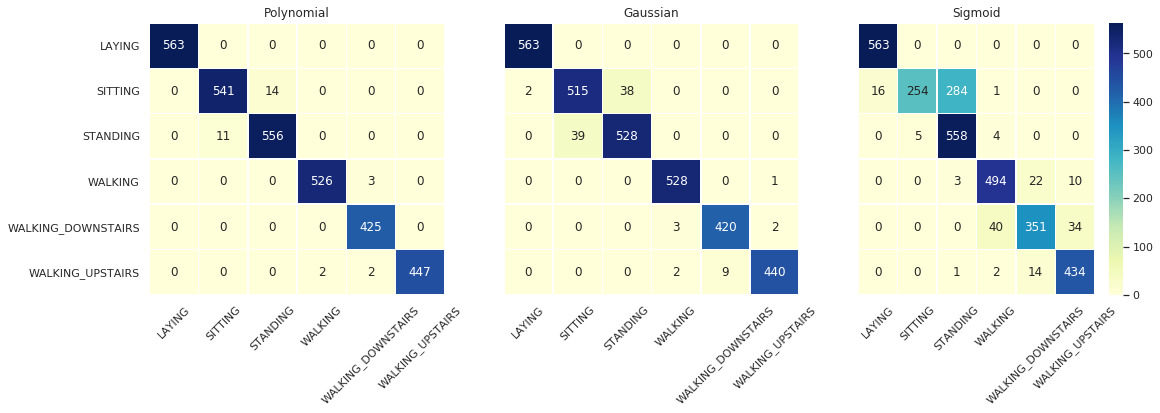

In [0]:
sns.set()
matrix_p = pd.DataFrame(confusion_matrix(y_test,y_ploy_pred), columns=labelencoder.classes_, index=labelencoder.classes_)
matrix_g = pd.DataFrame(confusion_matrix(y_test,y_rbf_pred), columns=labelencoder.classes_, index=labelencoder.classes_)
matrix_s = pd.DataFrame(confusion_matrix(y_test,y_sig_pred), columns=labelencoder.classes_, index=labelencoder.classes_)
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(18, 5))
sns.heatmap(matrix_p, annot=True, fmt='d', linewidths=.5, ax=ax1, cmap="YlGnBu", cbar=False)
sns.heatmap(matrix_g, annot=True, fmt='d', linewidths=.5, ax=ax2, cmap="YlGnBu", cbar=False)
sns.heatmap(matrix_s, annot=True, fmt='d', linewidths=.5, ax=ax3, cmap="YlGnBu")
ax2.set_yticklabels("")
ax3.set_yticklabels("")
ax1.set_title("Polynomial")
ax2.set_title("Gaussian")
ax3.set_title("Sigmoid")
ax1.set_xticklabels(labelencoder.classes_, rotation=45)
ax2.set_xticklabels(labelencoder.classes_, rotation=45)
ax3.set_xticklabels(labelencoder.classes_, rotation=45)

Visualization of confusion matrix of Random Forest

[Text(0.5, 0, 'LAYING'),
 Text(1.5, 0, 'SITTING'),
 Text(2.5, 0, 'STANDING'),
 Text(3.5, 0, 'WALKING'),
 Text(4.5, 0, 'WALKING_DOWNSTAIRS'),
 Text(5.5, 0, 'WALKING_UPSTAIRS')]

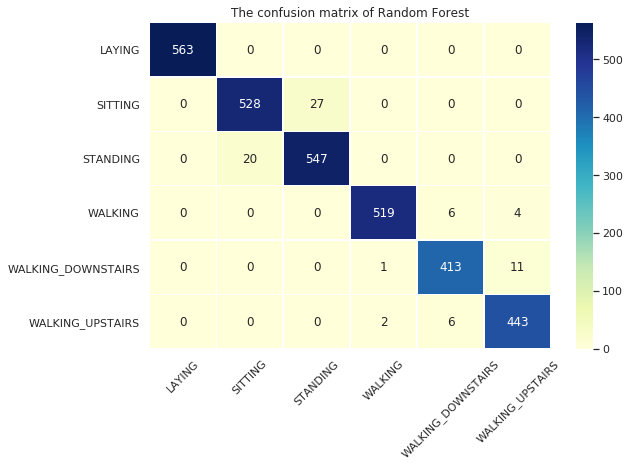

In [0]:
sns.set()
matrix_rf = pd.DataFrame(confusion_matrix(y_test, y_rfc_pred), columns=labelencoder.classes_, index=labelencoder.classes_)
f, ax = plt.subplots(figsize=(9,6))
sns.heatmap(matrix_rf, annot=True,  fmt='d', linewidths=.5, ax=ax, cmap="YlGnBu")
ax.set_title("The confusion matrix of Random Forest")
ax.set_xticklabels(labelencoder.classes_, rotation=45)

### 3.2.3 Tuning models

Tuning Gaussian kernel by Random gridsearch

In [0]:
# Kernels of linear and Gaussian
import time

Cs = [0.001, 0.01, 0.1, 1, 10]
gammas = [0.001, 0.01, 0.1, 1, 10]
param_grid = {'kernel':['rbf'], 'C': Cs, 'gamma':gammas}

# for kernels of linear
svc_rbf = SVC()
start = time.time()
randomsearch_rbf = RandomizedSearchCV(svc_rbf, param_grid)
randomsearch_rbf.fit(X_train, y_train)
print(randomsearch_rbf.best_estimator_, '\n',randomsearch_rbf.best_score_)
print("It cost", round((time.time()-start),2)) 

SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False) 
 0.9861287382298277
It cost 1798.21


In [0]:
# SVM with Gaussian Kernel after tuning
svclassifier_rbf = SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False) 
svclassifier_rbf.fit(X_train, y_train)
y_rbf_pred = svclassifier_rbf.predict(X_test)
s_rbf = round(svclassifier_rbf.score(X_test, y_test), 3)
c_rbf = confusion_matrix(y_test, y_rbf_pred)
cr_rbf = classification_report(y_test, y_rbf_pred)
print("The SVM accuracy score of Gaussian kernal is:{}".format(s_rbf))
print("The SVM confusion_matrix is:\n{}".format(c_rbf))
print("The SVM classification report is:\n{}".format(cr_rbf))

The SVM accuracy score of Gaussian kernal is:0.989
The SVM confusion_matrix is:
[[563   0   0   0   0   0]
 [  0 541  14   0   0   0]
 [  0  16 551   0   0   0]
 [  0   0   0 529   0   0]
 [  0   0   0   1 424   0]
 [  0   0   0   1   2 448]]
The SVM classification report is:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       563
           1       0.97      0.97      0.97       555
           2       0.98      0.97      0.97       567
           3       1.00      1.00      1.00       529
           4       1.00      1.00      1.00       425
           5       1.00      0.99      1.00       451

    accuracy                           0.99      3090
   macro avg       0.99      0.99      0.99      3090
weighted avg       0.99      0.99      0.99      3090



Tuning Polynomial kernel by grid search

In [0]:
param_grid = {'degree': [int(x) for x in np.linspace(start = 2, stop = 10, num = 9)]} # degree=1 is linear kernel
svc_poly = SVC(kernel='poly')
start = time.time()
gridsearch_poly = GridSearchCV(svc_poly, param_grid)
gridsearch_poly.fit(X_train, y_train)
print(gridsearch_poly.best_estimator_, '\n',gridsearch_poly.best_score_)
print("It cost", round((time.time()-start),2)) #485s in windows

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=6, gamma='scale', kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False) 
 0.987932078297453
It cost 200.87


In [0]:
svclassifier_ploy = SVC(kernel='poly',degree=6)
svclassifier_ploy.fit(X_train, y_train)
y_ploy_pred = svclassifier_ploy.predict(X_test)
s_ploy = round(svclassifier_ploy.score(X_test, y_test), 3)
c_ploy = confusion_matrix(y_test, y_ploy_pred)
cr_ploy = classification_report(y_test, y_ploy_pred)
print("The SVM accuracy score of Polynomial kernal is:{}".format(s_ploy))
print("The SVM confusion_matrix is:\n{}".format(c_ploy))
print("The SVM classification report is:\n{}".format(cr_ploy))

The SVM accuracy score of Polynomial kernal is:0.99
The SVM confusion_matrix is:
[[563   0   0   0   0   0]
 [  0 541  14   0   0   0]
 [  0  12 555   0   0   0]
 [  0   0   0 528   1   0]
 [  0   0   0   0 425   0]
 [  0   0   0   1   3 447]]
The SVM classification report is:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       563
           1       0.98      0.97      0.98       555
           2       0.98      0.98      0.98       567
           3       1.00      1.00      1.00       529
           4       0.99      1.00      1.00       425
           5       1.00      0.99      1.00       451

    accuracy                           0.99      3090
   macro avg       0.99      0.99      0.99      3090
weighted avg       0.99      0.99      0.99      3090



Tuning Random Forest

In [0]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

rf_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 54.9min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 225.2min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 404.5min finished


{'bootstrap': False,
 'max_depth': 40,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 1400}

In [0]:
best_random = rf_random.best_estimator_
y_rfc_pred = best_random.predict(X_test)
# Evaluation
print("The Random Forest accuracy classification score is", round(best_random.score(X_test, y_test),3))
print(confusion_matrix(y_test, y_rfc_pred))
print(classification_report(y_test, y_rfc_pred))

The Random Forest accuracy classification score is 0.98
[[563   0   0   0   0   0]
 [  0 531  24   0   0   0]
 [  0  14 553   0   0   0]
 [  0   0   0 519   6   4]
 [  0   0   0   0 417   8]
 [  0   0   0   1   5 445]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       563
           1       0.97      0.96      0.97       555
           2       0.96      0.98      0.97       567
           3       1.00      0.98      0.99       529
           4       0.97      0.98      0.98       425
           5       0.97      0.99      0.98       451

    accuracy                           0.98      3090
   macro avg       0.98      0.98      0.98      3090
weighted avg       0.98      0.98      0.98      3090



[Text(0.5, 0, 'LAYING'),
 Text(1.5, 0, 'SITTING'),
 Text(2.5, 0, 'STANDING'),
 Text(3.5, 0, 'WALKING'),
 Text(4.5, 0, 'WALKING_DOWNSTAIRS'),
 Text(5.5, 0, 'WALKING_UPSTAIRS')]

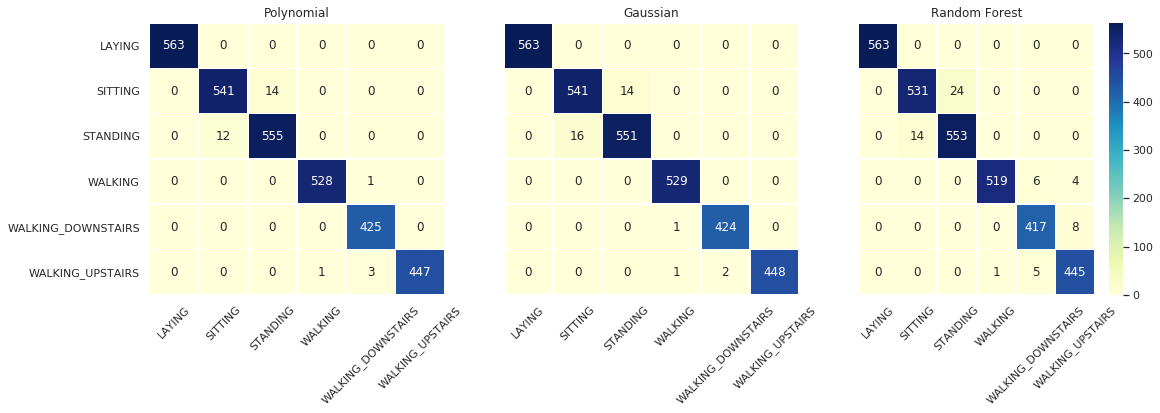

In [0]:
sns.set()
matrix_p = pd.DataFrame(confusion_matrix(y_test, y_ploy_pred), columns=labelencoder.classes_, index=labelencoder.classes_)
matrix_g = pd.DataFrame(confusion_matrix(y_test, y_rbf_pred), columns=labelencoder.classes_, index=labelencoder.classes_)
matrix_s = pd.DataFrame(confusion_matrix(y_test, y_rfc_pred), columns=labelencoder.classes_, index=labelencoder.classes_)
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(18, 5))
sns.heatmap(matrix_p, annot=True, fmt='d', linewidths=.5, ax=ax1, cmap="YlGnBu", cbar=False)
sns.heatmap(matrix_g, annot=True, fmt='d', linewidths=.5, ax=ax2, cmap="YlGnBu", cbar=False)
sns.heatmap(matrix_s, annot=True, fmt='d', linewidths=.5, ax=ax3, cmap="YlGnBu")
ax2.set_yticklabels("")
ax3.set_yticklabels("")
ax1.set_title("Polynomial")
ax2.set_title("Gaussian")
ax3.set_title("Random Forest")
ax1.set_xticklabels(labelencoder.classes_, rotation=45)
ax2.set_xticklabels(labelencoder.classes_, rotation=45)
ax3.set_xticklabels(labelencoder.classes_, rotation=45)

### 4.3 Feature importance

In [0]:
list(df.columns)

In [0]:
feature_importance = sorted(zip(map(lambda x: round(x, 4), rfc.feature_importances_), list(df.columns)), reverse=True)
main_feature = feature_importance.copy()
p = 0
for i, item in enumerate(main_feature):
  p += item[0]
  if p >= 0.9:
    print("The sum of feature importance is {0}, the index is {1}".format(p, i))
    break

The sum of feature importance is 0.9, the index is 223


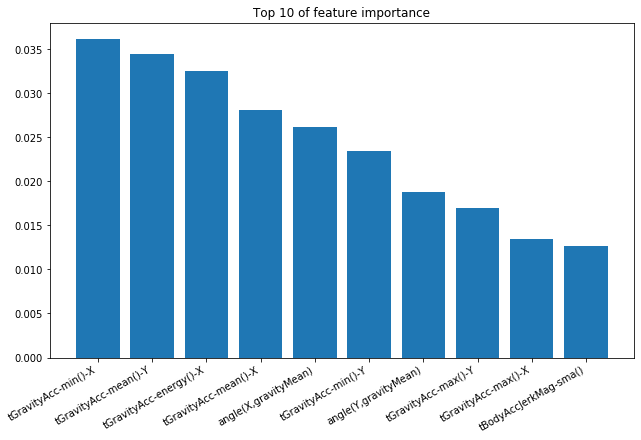

In [0]:
fig, ax = plt.subplots(figsize=(8.8, 6),constrained_layout=True)
plt.title("Top 10 of feature importance")
plt.bar(range(10), [item[0] for item in main_feature[:10]])
plt.xticks(range(10), [item[1] for item in feature_importance[:10]])
plt.setp(ax.get_xticklabels(), rotation=30, ha="right")
plt.show()

In [0]:
reduced_features = [item[1] for item in main_feature[:220]]
reduced_df = df[reduced_features].copy()
reduced_df.shape

(10299, 220)

In [0]:
# Seprate X and y
X = reduced_df.copy()

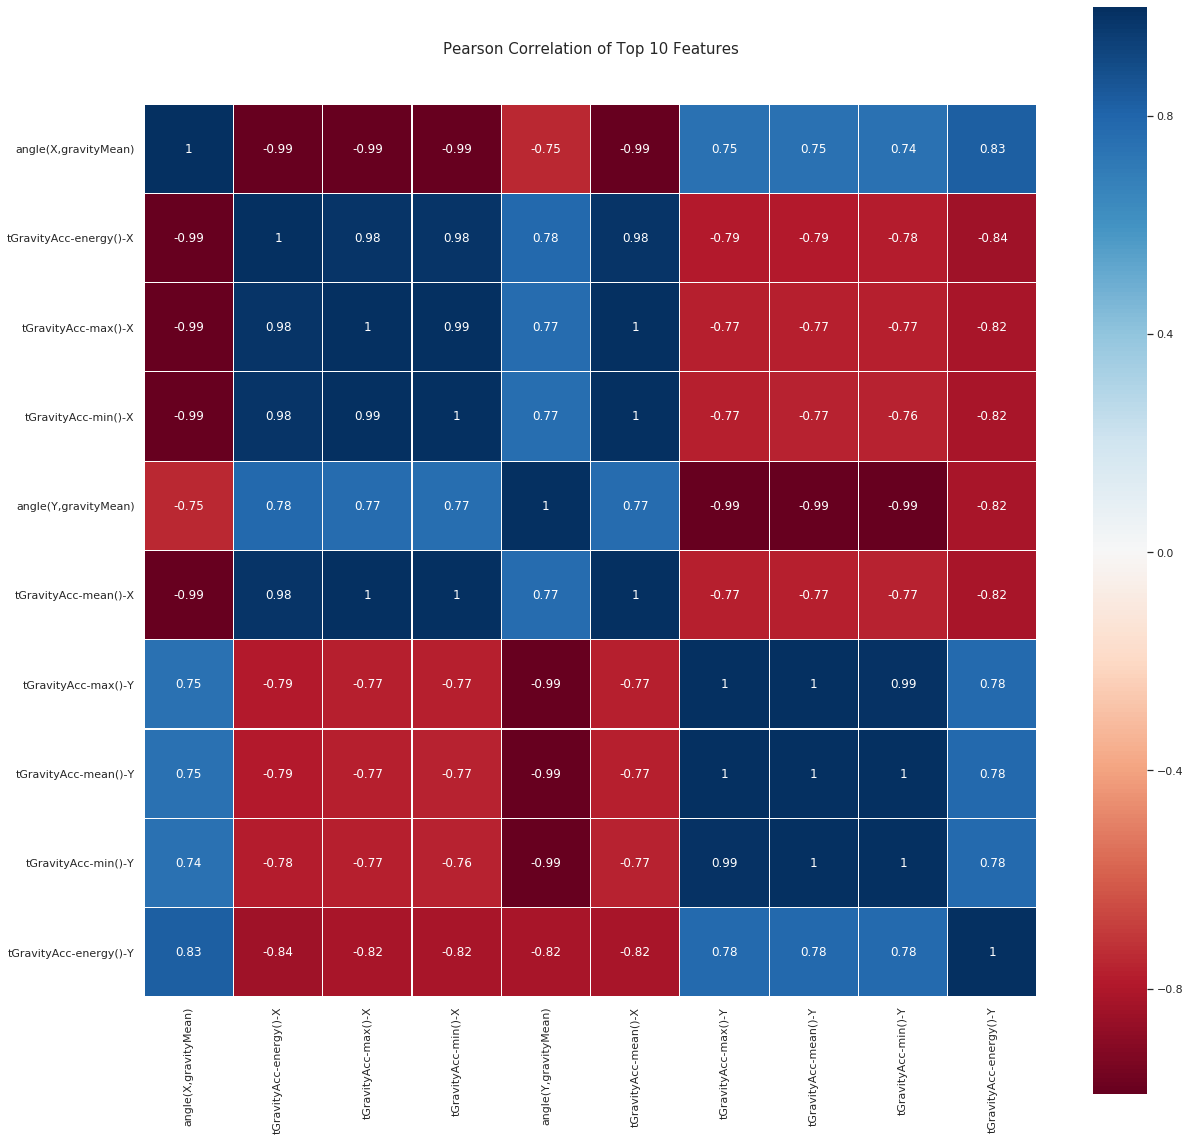

In [0]:
colormap = plt.cm.RdBu
plt.figure(figsize=(20,20))
plt.title('Pearson Correlation of Top 10 Features', y=1.05, size=15)
sns.heatmap(X.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

In [0]:
# Create correlation matrix
corr_matrix = X.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)] #13

X = X.drop(to_drop, axis=1)
y = df['Label']
# Split into traing, validation and test sets. 70:15:15
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [0]:
X_train.shape

(7209, 76)

In [0]:
svclassifier_ploy = SVC(kernel='poly',degree=6)
svclassifier_ploy.fit(X_train, y_train)
y_ploy_pred = svclassifier_ploy.predict(X_test)
s_ploy = round(svclassifier_ploy.score(X_test, y_test), 3)
c_ploy = confusion_matrix(y_test, y_ploy_pred)
cr_ploy = classification_report(y_test, y_ploy_pred)
print("The SVM accuracy score of Polynomial kernal is:{}".format(s_ploy))
print("The SVM confusion_matrix is:\n{}".format(c_ploy))
print("The SVM classification report is:\n{}".format(cr_ploy))

The SVM accuracy score of Polynomial kernal is:0.975
The SVM confusion_matrix is:
[[563   0   0   0   0   0]
 [  0 511  44   0   0   0]
 [  0  25 542   0   0   0]
 [  0   0   0 527   2   0]
 [  0   0   0   0 424   1]
 [  0   0   0   0   4 447]]
The SVM classification report is:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       563
           1       0.95      0.92      0.94       555
           2       0.92      0.96      0.94       567
           3       1.00      1.00      1.00       529
           4       0.99      1.00      0.99       425
           5       1.00      0.99      0.99       451

    accuracy                           0.98      3090
   macro avg       0.98      0.98      0.98      3090
weighted avg       0.98      0.98      0.98      3090



In [0]:
# SVM with Gaussian Kernel after tuning
svclassifier_rbf = SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False) 
svclassifier_rbf.fit(X_train, y_train)
y_rbf_pred = svclassifier_rbf.predict(X_test)
s_rbf = round(svclassifier_rbf.score(X_test, y_test), 3)
c_rbf = confusion_matrix(y_test, y_rbf_pred)
cr_rbf = classification_report(y_test, y_rbf_pred)
print("The SVM accuracy score of Gaussian kernal is:{}".format(s_rbf))
print("The SVM confusion_matrix is:\n{}".format(c_rbf))
print("The SVM classification report is:\n{}".format(cr_rbf))

The SVM accuracy score of Gaussian kernal is:0.962
The SVM confusion_matrix is:
[[563   0   0   0   0   0]
 [  0 505  50   0   0   0]
 [  0  45 522   0   0   0]
 [  0   0   0 526   0   3]
 [  0   0   0   2 419   4]
 [  0   0   0   4   9 438]]
The SVM classification report is:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       563
           1       0.92      0.91      0.91       555
           2       0.91      0.92      0.92       567
           3       0.99      0.99      0.99       529
           4       0.98      0.99      0.98       425
           5       0.98      0.97      0.98       451

    accuracy                           0.96      3090
   macro avg       0.96      0.96      0.96      3090
weighted avg       0.96      0.96      0.96      3090



In [0]:
# Random Forest
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
y_rfc_pred = rfc.predict(X_test)

# Random Forest
print("The Random Forest accuracy classification score is", round(rfc.score(X_test, y_test),3))
print(confusion_matrix(y_test, y_rfc_pred))
print(classification_report(y_test, y_rfc_pred))

The Random Forest accuracy classification score is 0.976
[[563   0   0   0   0   0]
 [  0 520  35   0   0   0]
 [  0  20 547   0   0   0]
 [  0   0   0 523   2   4]
 [  0   0   0   1 419   5]
 [  0   0   0   1   7 443]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       563
           1       0.96      0.94      0.95       555
           2       0.94      0.96      0.95       567
           3       1.00      0.99      0.99       529
           4       0.98      0.99      0.98       425
           5       0.98      0.98      0.98       451

    accuracy                           0.98      3090
   macro avg       0.98      0.98      0.98      3090
weighted avg       0.98      0.98      0.98      3090



[Text(0.5, 0, 'LAYING'),
 Text(1.5, 0, 'SITTING'),
 Text(2.5, 0, 'STANDING'),
 Text(3.5, 0, 'WALKING'),
 Text(4.5, 0, 'WALKING_DOWNSTAIRS'),
 Text(5.5, 0, 'WALKING_UPSTAIRS')]

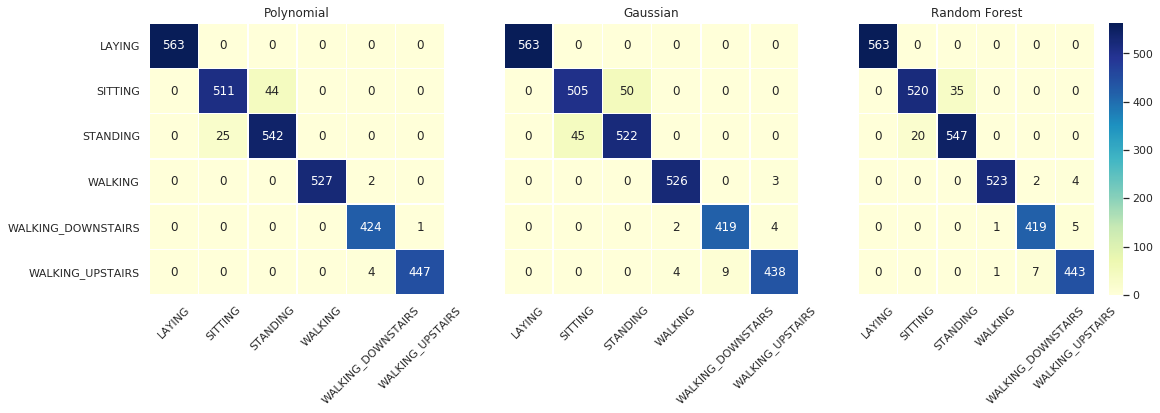

In [0]:
sns.set()
matrix_p = pd.DataFrame(confusion_matrix(y_test, y_ploy_pred), columns=labelencoder.classes_, index=labelencoder.classes_)
matrix_g = pd.DataFrame(confusion_matrix(y_test, y_rbf_pred), columns=labelencoder.classes_, index=labelencoder.classes_)
matrix_s = pd.DataFrame(confusion_matrix(y_test, y_rfc_pred), columns=labelencoder.classes_, index=labelencoder.classes_)
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(18, 5))
sns.heatmap(matrix_p, annot=True, fmt='d', linewidths=.5, ax=ax1, cmap="YlGnBu", cbar=False)
sns.heatmap(matrix_g, annot=True, fmt='d', linewidths=.5, ax=ax2, cmap="YlGnBu", cbar=False)
sns.heatmap(matrix_s, annot=True, fmt='d', linewidths=.5, ax=ax3, cmap="YlGnBu")
ax2.set_yticklabels("")
ax3.set_yticklabels("")
ax1.set_title("Polynomial")
ax2.set_title("Gaussian")
ax3.set_title("Random Forest")
ax1.set_xticklabels(labelencoder.classes_, rotation=45)
ax2.set_xticklabels(labelencoder.classes_, rotation=45)
ax3.set_xticklabels(labelencoder.classes_, rotation=45)

### PCA

https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60

In [0]:
labelencoder = LabelEncoder()
df['Label'] = labelencoder.fit_transform(df['Activity'])
# Seprate X and y
X = df.drop(['Activity', 'Label'], axis=1)

pca = PCA(n_components=100)
principalComponents = pca.fit_transform(X)
X = pd.DataFrame(data = principalComponents)

y = df['Label']
# Split into traing, validation and test sets. 70:15:15
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [0]:
#SVM with Gaussian Kernel after tuning
svclassifier_rbf = SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False) 
svclassifier_rbf.fit(X_train, y_train)
s_rbf = round(svclassifier_rbf.score(X_test, y_test), 3)
c_rbf = confusion_matrix(y_test, y_rbf_pred)
cr_rbf = classification_report(y_test, y_rbf_pred)
print("The SVM accuracy score of Gaussian kernal is:{}".format(s_rbf))
print("The SVM confusion_matrix is:\n{}".format(c_rbf))
print("The SVM classification report is:\n{}".format(cr_rbf))

The SVM accuracy score of Gaussian kernal is:0.988
The SVM confusion_matrix is:
[[563   0   0   0   0   0]
 [  7 479  69   0   0   0]
 [  0  48 519   0   0   0]
 [  0   0   0 521   3   5]
 [  0   0   0   5 410  10]
 [  0   0   0   5   9 437]]
The SVM classification report is:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       563
           1       0.91      0.86      0.89       555
           2       0.88      0.92      0.90       567
           3       0.98      0.98      0.98       529
           4       0.97      0.96      0.97       425
           5       0.97      0.97      0.97       451

    accuracy                           0.95      3090
   macro avg       0.95      0.95      0.95      3090
weighted avg       0.95      0.95      0.95      3090



In [0]:
# Random Forest
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
y_rfc_pred = rfc.predict(X_test)

# Random Forest
print("The Random Forest accuracy classification score is", round(rfc.score(X_test, y_test),3))
print(confusion_matrix(y_test, y_rfc_pred))
print(classification_report(y_test, y_rfc_pred))

The Random Forest accuracy classification score is 0.934
[[563   0   0   0   0   0]
 [ 12 471  72   0   0   0]
 [  0  57 510   0   0   0]
 [  0   0   1 521   3   4]
 [  0   0   0   9 388  28]
 [  0   0   0   3  14 434]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       563
           1       0.89      0.85      0.87       555
           2       0.87      0.90      0.89       567
           3       0.98      0.98      0.98       529
           4       0.96      0.91      0.93       425
           5       0.93      0.96      0.95       451

    accuracy                           0.93      3090
   macro avg       0.94      0.93      0.93      3090
weighted avg       0.93      0.93      0.93      3090



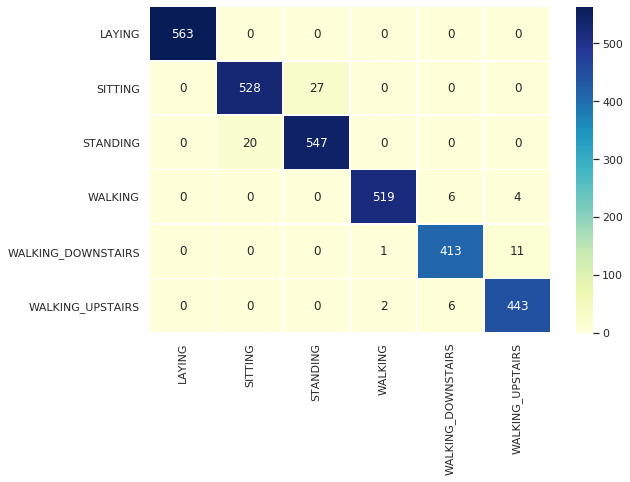

In [0]:
sns.set()
matrix_rf = pd.DataFrame(confusion_matrix(y_test, y_rfc_pred), columns=labelencoder.classes_, index=labelencoder.classes_)
f, ax = plt.subplots(figsize=(9,6))
sns.heatmap(matrix_rf, annot=True,  fmt='d', linewidths=.5, ax=ax, cmap="YlGnBu")

Draw accuracy vs PC

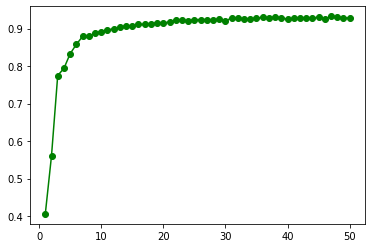

In [0]:
num = np.linspace(start=1, stop=50, num=50).astype(int)
labelencoder = LabelEncoder()
df['Label'] = labelencoder.fit_transform(df['Activity'])
# Seprate X and y
X = df.drop(['subject', 'Activity', 'Label'], axis=1)
y = df['Label']
accuracy_p = []

for i in num:
  pca = PCA(n_components=i)
  principalComponents = pca.fit_transform(X)
  X_pca = pd.DataFrame(data = principalComponents)
  X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=1)
  # Random Forest
  rfc = RandomForestClassifier()
  rfc.fit(X_train, y_train)
  y_rfc_pred = rfc.predict(X_test)
  accuracy_p.append(round(rfc.score(X_test, y_test),3))

plt.plot(num, accuracy_p, 'go-')

In [0]:
num = np.linspace(start=1, stop=50, num=50).astype(int)
labelencoder = LabelEncoder()
df['Label'] = labelencoder.fit_transform(df['Activity'])
# Seprate X and y
X = df.drop(['subject', 'Activity', 'Label'], axis=1)
y = df['Label']
accuracy_g = []

for i in num:
  pca = PCA(n_components=i)
  principalComponents = pca.fit_transform(X)
  X_pca = pd.DataFrame(data = principalComponents)
  X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=1)
  #SVM
  svclassifier_ploy = SVC(kernel='poly',degree=6)
  svclassifier_ploy.fit(X_train, y_train)
  y_ploy_pred = svclassifier_ploy.predict(X_test)
  accuracy_g.append(round(svclassifier_ploy.score(X_test, y_test), 3))

plt.plot(num, accuracy_g, 'bo-')

In [0]:
num = np.linspace(start=1, stop=50, num=50).astype(int)
labelencoder = LabelEncoder()
df['Label'] = labelencoder.fit_transform(df['Activity'])
# Seprate X and y
X = df.drop(['subject', 'Activity', 'Label'], axis=1)
y = df['Label']
accuracy_rf = []

for i in num:
  pca = PCA(n_components=i)
  principalComponents = pca.fit_transform(X)
  X_pca = pd.DataFrame(data = principalComponents)
  X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=1)
  #SVM
  svclassifier_rbf = SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False) 
  svclassifier_rbf.fit(X_train, y_train)
  y_rbf_pred = svclassifier_rbf.predict(X_test)  
  accuracy_rf.append(round(svclassifier_rbf.score(X_test, y_test), 3))

plt.plot(num, accuracy_rf, 'ro-')

In [0]:
def minimum_num(data, threshold):
  for i, v in enumerate(data):
    if v >= threshold:
      print("The number of component is {}, the accuracy is {}".format(i,v))
      break

threshold = 0.9
minimum_num(accuracy_p, threshold)
minimum_num(accuracy_g, threshold)
minimum_num(accuracy_rf, threshold)



The number of component is 12, the accuracy is 0.903
The number of component is 27, the accuracy is 0.902
The number of component is 9, the accuracy is 0.905


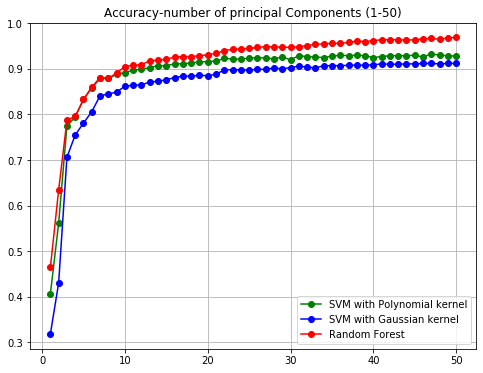

In [0]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(num, accuracy_p, 'go-', label='SVM with Polynomial kernel')
ax.plot(num, accuracy_g, 'bo-', label='SVM with Gaussian kernel')
ax.plot(num, accuracy_rf, 'ro-', label='Random Forest')
ax.set_title('Accuracy-number of principal Components (1-50)')
plt.legend()
plt.grid(True)
plt.show()